In [3]:
!pip install faiss_cpu

In [4]:
import json
import os
import re
import numpy as np
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import DataLoader
import faiss
import time
import os
import zipfile
import shutil
import glob
import google.generativeai as genai
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import random

In [5]:
zip_file_path = '/content/dataset.zip'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"Zip file '{zip_file_path}' has been extracted successfully.")
except FileNotFoundError:
    print(f"Error: Zip file not found at '{zip_file_path}'")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Zip file '/content/dataset.zip' has been extracted successfully.


In [6]:
# --- Konfigurasi ---
BASE_DIR = "dataset/SistemOperasi"  # Direktori utama mata kuliah Anda
OUTLINE_FILE = os.path.join(BASE_DIR, "outline_operating_systems.txt")

# --- Path untuk Artefak Model Dasar (Baseline) ---
BASE_EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2'
OUTPUT_JSON_CHUNKS_BASE = os.path.join(BASE_DIR, "processed_chunks_metadata_base.json")
OUTPUT_FAISS_INDEX_BASE = os.path.join(BASE_DIR, "vector_store_base.index")

# --- Path untuk Artefak Model Fine-Tuned ---
# Ini akan menjadi output utama yang digunakan aplikasi jika fine-tuning berhasil
FINETUNED_EMBEDDING_MODEL_SAVE_PATH = os.path.join(BASE_DIR, "finetuned_embedding_model_sistem_operasi")
FINETUNED_MODEL_ZIP_PATH = os.path.join(BASE_DIR, "finetuned_embedding_model_sistem_operasi.zip")
OUTPUT_JSON_CHUNKS_FINETUNED = os.path.join(BASE_DIR, "processed_chunks_metadata_finetuned.json")
OUTPUT_FAISS_INDEX_FINETUNED = os.path.join(BASE_DIR, "vector_store_finetuned.index")


# --- File Dataset ---
EMBEDDING_FINETUNING_DATASET_FILE = os.path.join(BASE_DIR, "embedding_finetuning_examples.jsonl")
EMBEDDING_EVALUATION_SET_FILE = os.path.join(BASE_DIR, "embedding_evaluation_set.jsonl")


# --- Parameter ---
MAX_CHUNK_SIZE_CHARS = 1000
CHUNK_OVERLAP_CHARS = 150
HEADING_SPLIT_PATTERN = r"(^#{1,6}\s+.*$)"
FINETUNE_EPOCHS = 3 # Sesuaikan berdasarkan dataset Anda
FINETUNE_BATCH_SIZE = 16
EVALUATION_TOP_K = 5 # Untuk Recall@K dan MRR@K
FINETUNE_BATCH_SIZE = 16

In [30]:
# --- Fungsi Helper (Parsing, Chunking - sebagian besar sama) ---
def parse_outline(outline_filepath):
    pertemuan_list = []
    try:
        with open(outline_filepath, 'r', encoding='utf-8') as f:
            content = f.read()
        if not content.strip().startswith("MATAKULIAH:"):
            print(f"Peringatan: Format file outline '{outline_filepath}' mungkin tidak sesuai.")
        pertemuan_blocks = re.split(r'\nPERTEMUAN:', '\n' + content.split('PERTEMUAN:', 1)[-1] if 'PERTEMUAN:' in content else '')
        for block in pertemuan_blocks:
            if not block.strip(): continue
            current_pertemuan = {}
            lines = block.strip().splitlines()
            if lines:
                pertemuan_id_match = re.match(r'^\s*(\d+)', lines[0])
                if pertemuan_id_match: current_pertemuan['id'] = int(pertemuan_id_match.group(1))
                else: continue # Skip jika tidak ada ID
                for line_idx, line_content in enumerate(lines): # Ganti nama variabel 'line'
                    if ":" in line_content:
                        key, value = line_content.split(":", 1)
                        key_clean = key.strip().lower().replace(" ", "_")
                        value_clean = value.strip()
                        current_pertemuan[key_clean] = value_clean
            if 'id' in current_pertemuan and 'judul' in current_pertemuan and current_pertemuan.get('file_materi'):
                pertemuan_list.append(current_pertemuan)
            elif 'id' in current_pertemuan:
                 print(f"Info: Pertemuan {current_pertemuan.get('id','N/A')} ({current_pertemuan.get('judul','Tanpa Judul')}) dilewati (mungkin kurang file_materi atau judul).")
    except FileNotFoundError: print(f"Error: File outline '{outline_filepath}' tidak ditemukan.")
    except Exception as e: print(f"Error saat mem-parsing file outline: {e}")
    print(f"Berhasil mem-parsing {len(pertemuan_list)} pertemuan dengan file materi dari outline.")
    return pertemuan_list

def read_material_text(material_filepath):
    try:
        with open(material_filepath, 'r', encoding='utf-8') as f: return f.read()
    except FileNotFoundError: print(f"Error: File materi '{material_filepath}' tidak ditemukan."); return ""
    except Exception as e: print(f"Error saat membaca file materi '{material_filepath}': {e}"); return ""

def _split_text_block_sliding_window(text_block, pertemuan_id, pertemuan_judul, heading, max_size, overlap):
    final_chunks = []
    text_block_stripped = text_block.strip()
    if not text_block_stripped: return []
    if len(text_block_stripped) <= max_size:
        final_chunks.append({"pertemuan_id": pertemuan_id, "pertemuan_judul": pertemuan_judul, "original_heading": heading, "chunk_text": text_block_stripped, "chunk_id": f"p{pertemuan_id}_h{hash(heading)}_{len(final_chunks)}"})
    else:
        start_index = 0; doc_len = len(text_block_stripped)
        while start_index < doc_len:
            end_index = start_index + max_size
            current_slice = text_block_stripped[start_index:min(end_index, doc_len)]
            if current_slice.strip():
                final_chunks.append({"pertemuan_id": pertemuan_id, "pertemuan_judul": pertemuan_judul, "original_heading": heading, "chunk_text": current_slice.strip(), "chunk_id": f"p{pertemuan_id}_h{hash(heading)}_{len(final_chunks)}"})
            if min(end_index, doc_len) >= doc_len: break
            start_index += (max_size - overlap)
            if start_index >= doc_len: break
    return final_chunks

def chunk_material_heading_aware(text_content, pertemuan_id, pertemuan_judul):
    processed_chunks = []; current_chunk_idx = 0
    if not text_content or not text_content.strip(): return []
    parts = re.split(HEADING_SPLIT_PATTERN, text_content, flags=re.MULTILINE)
    current_heading = "Umum"; accumulated_text_for_section = ""
    for i, part in enumerate(parts):
        part_stripped = part.strip()
        if not part_stripped: continue
        is_current_part_a_heading = re.match(HEADING_SPLIT_PATTERN, part_stripped, flags=re.MULTILINE)
        if is_current_part_a_heading:
            if accumulated_text_for_section.strip():
                sub_chunks = _split_text_block_sliding_window(accumulated_text_for_section, pertemuan_id, pertemuan_judul, current_heading, MAX_CHUNK_SIZE_CHARS, CHUNK_OVERLAP_CHARS)
                for sc_idx, sc in enumerate(sub_chunks): sc['chunk_id'] = f"p{pertemuan_id}_s{i}_sc{sc_idx}"; processed_chunks.append(sc) # ID chunk yang lebih unik
            current_heading = part_stripped; accumulated_text_for_section = ""
        else: accumulated_text_for_section += part_stripped + "\n"
    if accumulated_text_for_section.strip():
        sub_chunks = _split_text_block_sliding_window(accumulated_text_for_section, pertemuan_id, pertemuan_judul, current_heading, MAX_CHUNK_SIZE_CHARS, CHUNK_OVERLAP_CHARS)
        for sc_idx, sc in enumerate(sub_chunks): sc['chunk_id'] = f"p{pertemuan_id}_s_last_sc{sc_idx}"; processed_chunks.append(sc)
    return processed_chunks

def get_text_embeddings_from_model(list_of_chunk_texts, embedding_model_instance):
    if not list_of_chunk_texts: print("Tidak ada teks untuk di-embed."); return np.array([])
    try:
        print(f"Memulai proses embedding untuk {len(list_of_chunk_texts)} chunk teks...")
        embeddings = embedding_model_instance.encode(list_of_chunk_texts, show_progress_bar=True, batch_size=128)
        print(f"Proses embedding selesai. Dihasilkan {embeddings.shape[0]} embeddings dengan dimensi {embeddings.shape[1]}.")
        return embeddings
    except Exception as e: print(f"Error saat membuat embeddings: {e}"); return np.array([])

def create_and_save_faiss_index(embeddings_np_array, index_output_path):
    if embeddings_np_array.size == 0 or embeddings_np_array.ndim != 2: print("Array embedding kosong. FAISS index tidak dibuat."); return False
    dimension = embeddings_np_array.shape[1]
    try:
        print(f"Membuat FAISS index dengan dimensi {dimension}...")
        index = faiss.IndexFlatL2(dimension)
        index.add(embeddings_np_array.astype('float32'))
        faiss.write_index(index, index_output_path)
        print(f"FAISS index dengan {index.ntotal} vektor disimpan ke: {index_output_path}")
        return True
    except Exception as e: print(f"Error saat membuat/menyimpan FAISS index: {e}"); return False

def save_chunks_to_json(chunks_with_metadata, json_output_path):
    try:
        with open(json_output_path, "w", encoding="utf-8") as f:
            json.dump(chunks_with_metadata, f, ensure_ascii=False, indent=2)
        print(f"Semua chunk ({len(chunks_with_metadata)}) berhasil disimpan ke: {json_output_path}")
        return True
    except Exception as e: print(f"Error saat menyimpan chunks ke JSON: {e}"); return False

# --- Fungsi Fine-Tuning & Evaluasi Embedding ---
def load_embedding_finetuning_dataset(filepath):
    train_examples = []
    if not os.path.exists(filepath): print(f"PERINGATAN: File dataset fine-tuning '{filepath}' tidak ditemukan."); return []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line_num, line_content in enumerate(f):
            try:
                data = json.loads(line_content)
                if "query" in data and "positive_passage" in data:
                    train_examples.append(InputExample(texts=[data["query"], data["positive_passage"]]))
                else: print(f"Peringatan: Baris data tidak valid di {filepath} (baris {line_num+1})")
            except json.JSONDecodeError: print(f"Peringatan: Gagal parsing JSON di {filepath} (baris {line_num+1})")
    print(f"Berhasil memuat {len(train_examples)} contoh dari {filepath} untuk fine-tuning embedding.")
    return train_examples

def finetune_embedding_model(base_model_name, train_examples, output_path, epochs, batch_size):
    if not train_examples:
        print("Tidak ada data training. Fine-tuning embedding dilewati.")
        return None

    print(f"Memulai fine-tuning model embedding '{base_model_name}'...")
    start_time = time.time()

    os.environ["WANDB_DISABLED"] = "true"

    model = SentenceTransformer(base_model_name)
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
    train_loss = losses.MultipleNegativesRankingLoss(model=model)

    os.makedirs(output_path, exist_ok=True)

    model.fit(train_objectives=[(train_dataloader, train_loss)],
              epochs=epochs,
              warmup_steps=int(len(train_dataloader) * epochs * 0.1),
              output_path=output_path,
              show_progress_bar=True,
              save_best_model=False)

    end_time = time.time()
    print(f"Fine-tuning selesai dalam {end_time - start_time:.2f} detik. Model disimpan di: {output_path}")

    try:
        return SentenceTransformer(output_path)
    except Exception as e:
        print(f"Peringatan: Gagal memuat model dari '{output_path}' setelah fine-tuning: {e}")
        print("Mengembalikan None. Periksa apakah direktori model berisi semua file yang diperlukan.")
        return None

def load_embedding_evaluation_dataset(filepath):
    eval_data = []
    if not os.path.exists(filepath): print(f"PERINGATAN: File dataset evaluasi '{filepath}' tidak ditemukan."); return []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line_num, line_content in enumerate(f):
            try:
                data = json.loads(line_content)
                if "query_id" in data and "query_text" in data and "relevant_passage_text" in data: # Ganti nama field
                    eval_data.append(data)
                else: print(f"Peringatan: Baris data evaluasi tidak valid di {filepath} (baris {line_num+1})")
            except json.JSONDecodeError: print(f"Peringatan: Gagal parsing JSON di data evaluasi {filepath} (baris {line_num+1})")
    print(f"Berhasil memuat {len(eval_data)} contoh dari {filepath} untuk evaluasi embedding.")
    return eval_data

def evaluate_retrieval_performance(embedding_model_instance, faiss_index_instance, text_chunks_list, eval_dataset, top_k):
    if not eval_dataset or embedding_model_instance is None or faiss_index_instance is None or not text_chunks_list:
        print("Input tidak lengkap untuk evaluasi retrieval. Dilewati.")
        return {"avg_recall_at_k": 0, "avg_mrr_at_k": 0, "queries_evaluated": 0}

    total_recall = 0; total_mrr = 0; queries_evaluated = 0
    for item in eval_dataset:
        query_text = item["query_text"]
        relevant_passage_ground_truth = item["relevant_passage_text"].strip().lower()

        query_embedding = embedding_model_instance.encode([query_text])[0]
        query_np_array = np.array([query_embedding]).astype('float32')

        if faiss_index_instance.d != query_np_array.shape[1]:
            print(f"  Peringatan Evaluasi: Dimensi embedding query ({query_np_array.shape[1]}) tidak cocok dengan FAISS ({faiss_index_instance.d}).")
            continue

        distances, global_indices = faiss_index_instance.search(query_np_array, min(top_k, faiss_index_instance.ntotal))

        retrieved_passages = []
        for i in global_indices[0]:
            if i != -1 and 0 <= i < len(text_chunks_list):
                retrieved_passages.append(text_chunks_list[i]["chunk_text"].strip().lower())

        found_in_top_k = False
        rank = 0
        for idx, passage in enumerate(retrieved_passages):
            if relevant_passage_ground_truth in passage: # Menggunakan 'in' untuk pencocokan substring
                if not found_in_top_k: # Hanya hitung rank pertama kali ditemukan
                    rank = idx + 1
                    total_mrr += 1.0 / rank
                found_in_top_k = True
                break # Hentikan pencarian jika sudah ditemukan

        if found_in_top_k: total_recall += 1
        queries_evaluated += 1

    avg_recall = total_recall / queries_evaluated if queries_evaluated > 0 else 0
    avg_mrr = total_mrr / queries_evaluated if queries_evaluated > 0 else 0
    return {"avg_recall_at_k": avg_recall, "avg_mrr_at_k": avg_mrr, "queries_evaluated": queries_evaluated}

def zip_model_directory(directory_path, zip_output_path):
    if not os.path.isdir(directory_path):
        print(f"Error: Direktori model '{directory_path}' tidak ditemukan. Tidak dapat membuat zip.")
        return False
    try:
        # Hapus file zip lama jika ada
        if os.path.exists(zip_output_path):
            os.remove(zip_output_path)
            print(f"File zip lama '{zip_output_path}' dihapus.")

        shutil.make_archive(zip_output_path.replace('.zip',''), 'zip', directory_path) # make_archive menambahkan .zip otomatis
        print(f"Model berhasil di-zip ke: {zip_output_path}")
        return True
    except Exception as e:
        print(f"Error saat membuat arsip zip: {e}")
        return False

In [31]:
def generate_queries_from_passage_with_llm(passage_text, llm_model_instance, num_queries=1, max_retries=2, delay_between_retries=5):
    """
    Menghasilkan pertanyaan dari sebuah passage menggunakan LLM (Gemini).
    """
    if not llm_model_instance:
        print("  LLM model instance tidak tersedia untuk question generation.")
        return []

    prompt = f"""Anda adalah seorang ahli dalam membuat pertanyaan berdasarkan teks yang diberikan.
Berdasarkan teks berikut, buatlah {num_queries} pertanyaan yang spesifik, jelas, dan bisa dijawab secara langsung oleh teks tersebut.
Setiap pertanyaan harus berbeda. Kembalikan hanya daftar pertanyaan, masing-masing dalam baris baru, tanpa nomor atau bullet point.

Teks:
\"\"\"
{passage_text[:1500]}
\"\"\"

Pertanyaan:
"""
    # Batasi panjang passage untuk efisiensi prompt

    for attempt in range(max_retries):
        try:
            response = llm_model_instance.generate_content(prompt)
            # Cek apakah ada 'parts' dan ambil teksnya, atau langsung dari 'text'
            if hasattr(response, 'parts') and response.parts:
                generated_text = "".join(part.text for part in response.parts)
            elif hasattr(response, 'text') and response.text:
                generated_text = response.text
            else: # Jika tidak ada parts atau text, coba cek prompt_feedback
                if hasattr(response, 'prompt_feedback') and response.prompt_feedback.block_reason:
                    print(f"  Peringatan LLM QGen: Respons diblokir. Alasan: {response.prompt_feedback.block_reason_message}")
                else:
                    print(f"  Peringatan LLM QGen: Respons tidak memiliki format teks yang diharapkan. Respons: {response}")
                generated_text = ""

            questions = [q.strip() for q in generated_text.splitlines() if q.strip()]

            if questions: # Jika berhasil mendapatkan pertanyaan
                # Pastikan tidak ada pertanyaan kosong setelah strip
                questions = [q for q in questions if q]
                if questions:
                     print(f"  LLM berhasil generate {len(questions)} pertanyaan untuk passage.")
                     return questions[:num_queries] # Ambil sejumlah num_queries

            print(f"  LLM tidak menghasilkan pertanyaan yang valid (attempt {attempt + 1}/{max_retries}). Respons mentah: '{generated_text}'")

        except Exception as e:
            print(f"  Error saat memanggil LLM untuk question generation (attempt {attempt + 1}/{max_retries}): {e}")

        if attempt < max_retries - 1:
            print(f"  Menunggu {delay_between_retries} detik sebelum mencoba lagi...")
            time.sleep(delay_between_retries)

    return []


def create_embedding_finetune_dataset_with_llm(
    all_processed_chunks,
    llm_model_instance_for_qgen,
    num_queries_per_chunk=1,
    output_filepath=None,
    max_chunks_to_process=None # Opsional: batasi jumlah chunk untuk diolah (untuk testing)
):
    """
    Membuat dataset fine-tuning (query, positive_passage) menggunakan LLM untuk membuat query.
    Menyimpan hasilnya ke output_filepath jika diberikan.
    """
    train_examples_data = []

    chunks_to_process = all_processed_chunks
    if max_chunks_to_process is not None:
        chunks_to_process = all_processed_chunks[:max_chunks_to_process]
        print(f"Memproses {max_chunks_to_process} chunk pertama untuk pembuatan dataset fine-tuning dengan LLM.")

    processed_count = 0
    for i, chunk_data in enumerate(chunks_to_process):
        print(f"Memproses chunk {i+1}/{len(chunks_to_process)} untuk Q-Gen...")
        passage = chunk_data["chunk_text"]
        generated_queries = generate_queries_from_passage_with_llm(
            passage, llm_model_instance_for_qgen, num_queries_per_chunk
        )
        for query in generated_queries:
            train_examples_data.append({"query": query, "positive_passage": passage})

        processed_count +=1
        # Opsional: tambahkan delay kecil untuk menghindari rate limit API
        if processed_count % 10 == 0: # Setiap 10 chunk
             time.sleep(1)


    if output_filepath and train_examples_data:
        try:
            with open(output_filepath, 'w', encoding='utf-8') as f:
                for example in train_examples_data:
                    f.write(json.dumps(example) + '\n')
            print(f"Dataset fine-tuning embedding ({len(train_examples_data)} contoh) berhasil dibuat dan disimpan di: {output_filepath}")
        except Exception as e:
            print(f"Error saat menyimpan dataset fine-tuning ke {output_filepath}: {e}")
    elif not train_examples_data:
        print("Tidak ada contoh fine-tuning yang berhasil dibuat dengan LLM.")

    # Mengembalikan format InputExample jika ingin langsung digunakan untuk training
    # atau biarkan skrip utama yang memanggil `load_embedding_finetuning_dataset`
    # Untuk konsistensi, kita simpan ke file dan biarkan `load_embedding_finetuning_dataset` yang memuatnya.
    return train_examples_data # Mengembalikan list of dicts

In [32]:
# Tambahkan cell baru setelah cell yang ada
def create_evaluation_dataset_from_chunks(all_processed_chunks, output_filepath, sample_size=20):
    """
    Membuat dataset evaluasi dari chunks yang ada.
    Format: {query_id, query_text, relevant_passage_text}
    """
    if not all_processed_chunks:
        print("Tidak ada chunks untuk membuat dataset evaluasi")
        return []

    eval_data = []

    # Ambil sample chunks untuk evaluasi
    sample_chunks = random.sample(all_processed_chunks, min(sample_size, len(all_processed_chunks)))

    for i, chunk in enumerate(sample_chunks):
        chunk_text = chunk['chunk_text']
        pertemuan_judul = chunk.get('pertemuan_judul', 'Unknown')

        # Buat beberapa query sederhana dari chunk
        simple_queries = [
            f"Apa yang dibahas tentang {pertemuan_judul}?",
            f"Jelaskan konsep dalam {pertemuan_judul}",
            f"Bagaimana cara kerja {pertemuan_judul}?",
            "Apa definisi dari konsep ini?",
            "Bagaimana implementasinya?"
        ]

        # Pilih query yang paling sesuai berdasarkan panjang chunk
        if len(chunk_text) > 500:
            selected_query = simple_queries[0]  # Query yang lebih spesifik
        else:
            selected_query = simple_queries[3]  # Query yang lebih umum

        eval_data.append({
            "query_id": f"eval_{i}",
            "query_text": selected_query,
            "relevant_passage_text": chunk_text,
            "pertemuan_id": chunk.get('pertemuan_id'),
            "chunk_id": chunk.get('chunk_id', f"chunk_{i}")
        })

    # Simpan ke file jika path diberikan
    if output_filepath:
        try:
            with open(output_filepath, 'w', encoding='utf-8') as f:
                for item in eval_data:
                    f.write(json.dumps(item, ensure_ascii=False) + '\n')
            print(f"Dataset evaluasi ({len(eval_data)} items) berhasil dibuat: {output_filepath}")
        except Exception as e:
            print(f"Error menyimpan dataset evaluasi: {e}")

    return eval_data

# Buat dataset evaluasi jika belum ada
if not os.path.exists(EMBEDDING_EVALUATION_SET_FILE):
    print(f"\n--- Membuat Dataset Evaluasi ---")
    print(f"File {EMBEDDING_EVALUATION_SET_FILE} tidak ditemukan. Membuat dataset evaluasi...")

    eval_dataset = create_evaluation_dataset_from_chunks(
        all_processed_chunks_with_metadata,
        EMBEDDING_EVALUATION_SET_FILE,
        sample_size=15  # Buat 15 query evaluasi
    )

    # Reload evaluation examples setelah dibuat
    embedding_evaluation_examples = load_embedding_evaluation_dataset(EMBEDDING_EVALUATION_SET_FILE)
    print(f"Dataset evaluasi berhasil dibuat dan dimuat: {len(embedding_evaluation_examples)} items")

In [33]:
from google.colab import userdata

print("Memulai Persiapan Data, Fine-Tuning, dan Evaluasi Embedding...")

# 1. Parse outline & Buat Chunks Materi (dilakukan sekali)
print(f"\n--- Langkah 1: Memproses Materi Kuliah ---")
daftar_pertemuan = parse_outline(OUTLINE_FILE)
all_processed_chunks_with_metadata = []

llm_for_qgen = None
GEMINI_API_KEY_FOR_PREP = userdata.get('GEMINI')

if GEMINI_API_KEY_FOR_PREP:
    try:
        genai.configure(api_key=GEMINI_API_KEY_FOR_PREP)
        print("Gemini API berhasil dikonfigurasi (atau dikonfigurasi ulang) dengan API Key dari userdata.")

        llm_for_qgen = genai.GenerativeModel('gemini-1.5-flash-latest')
        print("Model LLM ('gemini-1.5-flash-latest') untuk Question Generation berhasil dimuat.")

    except Exception as e:
        print(f"Peringatan: Terjadi kesalahan saat mengkonfigurasi atau memuat model Gemini untuk QGen: {e}")
        llm_for_qgen = None
else:
    print("PERINGATAN: Secret 'GEMINI' (API Key) tidak ditemukan di Colab userdata. Question Generation dengan LLM akan dilewati.")


Memulai Persiapan Data, Fine-Tuning, dan Evaluasi Embedding...

--- Langkah 1: Memproses Materi Kuliah ---
Berhasil mem-parsing 4 pertemuan dengan file materi dari outline.
Gemini API berhasil dikonfigurasi (atau dikonfigurasi ulang) dengan API Key dari userdata.
Model LLM ('gemini-1.5-flash-latest') untuk Question Generation berhasil dimuat.


In [34]:
if daftar_pertemuan:
    for pertemuan_info in daftar_pertemuan:
        file_materi_abs_path = os.path.join(BASE_DIR, pertemuan_info.get('file_materi',''))
        materi_text = read_material_text(file_materi_abs_path)
        if materi_text:
            chunks_for_this_pertemuan = chunk_material_heading_aware(materi_text, pertemuan_info.get('id'), pertemuan_info.get('judul'))
            all_processed_chunks_with_metadata.extend(chunks_for_this_pertemuan)
    print(f"Total chunk materi yang diproses: {len(all_processed_chunks_with_metadata)}")
else:
    print("Gagal mem-parsing outline atau tidak ada materi. Proses dihentikan.")
    exit()

if not all_processed_chunks_with_metadata:
    print("Tidak ada chunk materi yang berhasil dibuat. Proses dihentikan.")
    exit()

list_of_chunk_texts_for_embedding = [chunk['chunk_text'] for chunk in all_processed_chunks_with_metadata]

Total chunk materi yang diproses: 56


In [35]:
if not os.path.exists(EMBEDDING_FINETUNING_DATASET_FILE) and llm_for_qgen and all_processed_chunks_with_metadata:
    print(f"\n--- Langkah Opsional: Membuat Dataset Fine-tuning Embedding dengan LLM ---")
    print(f"File {EMBEDDING_FINETUNING_DATASET_FILE} tidak ditemukan. Mencoba membuat secara otomatis...")
    create_embedding_finetune_dataset_with_llm(
        all_processed_chunks_with_metadata,
        llm_for_qgen,
        num_queries_per_chunk=1, # Buat 1 pertanyaan per chunk
        output_filepath=EMBEDDING_FINETUNING_DATASET_FILE,
        max_chunks_to_process=15 # Hapus atau naikkan angka ini untuk memproses semua chunk
                                  # Gunakan angka kecil untuk testing agar tidak lama dan boros API call.
    )
elif not llm_for_qgen and not os.path.exists(EMBEDDING_FINETUNING_DATASET_FILE):
    print(f"PERINGATAN: LLM untuk Q-Gen tidak tersedia DAN file {EMBEDDING_FINETUNING_DATASET_FILE} tidak ada. Fine-tuning akan dilewati.")

In [36]:
# 2. Muat dataset untuk fine-tuning dan evaluasi
print(f"\n--- Langkah 2: Memuat Dataset Tambahan ---")
embedding_finetune_examples = load_embedding_finetuning_dataset(EMBEDDING_FINETUNING_DATASET_FILE)
embedding_evaluation_examples = load_embedding_evaluation_dataset(EMBEDDING_EVALUATION_SET_FILE)
metrics_base = None
metrics_finetuned = None

# --- BASELINE MODEL: Pembuatan Artefak & Evaluasi ---
print(f"\n--- Langkah 3: Memproses dengan Model Embedding Dasar ({BASE_EMBEDDING_MODEL_NAME}) ---")
base_embedding_model_instance = SentenceTransformer(BASE_EMBEDDING_MODEL_NAME)
base_document_embeddings = get_text_embeddings_from_model(list_of_chunk_texts_for_embedding, base_embedding_model_instance)

base_faiss_created = False
if base_document_embeddings.size > 0:
    base_faiss_created = create_and_save_faiss_index(base_document_embeddings, OUTPUT_FAISS_INDEX_BASE)
    save_chunks_to_json(all_processed_chunks_with_metadata, OUTPUT_JSON_CHUNKS_BASE) # Simpan chunks yang sesuai

if base_faiss_created and embedding_evaluation_examples:
    print(f"\n--- Langkah 3.1: Evaluasi Performa Retrieval Model Dasar ---")
    # Muat FAISS index yang baru dibuat untuk evaluasi
    base_faiss_index_for_eval = faiss.read_index(OUTPUT_FAISS_INDEX_BASE)
    metrics_base = evaluate_retrieval_performance(
        base_embedding_model_instance, base_faiss_index_for_eval, all_processed_chunks_with_metadata,
        embedding_evaluation_examples, EVALUATION_TOP_K
    )
    print(f"Metrik Model Dasar: Recall@{EVALUATION_TOP_K}={metrics_base['avg_recall_at_k']:.4f}, MRR@{EVALUATION_TOP_K}={metrics_base['avg_mrr_at_k']:.4f} ({metrics_base['queries_evaluated']} queries)")

# --- FINE-TUNING EMBEDDING MODEL ---
print(f"\n--- Langkah 4: Fine-Tuning Model Embedding ---")
finetuned_embedding_model_instance = None
if embedding_finetune_examples:
    finetuned_embedding_model_instance = finetune_embedding_model(
        BASE_EMBEDDING_MODEL_NAME, embedding_finetune_examples,
        FINETUNED_EMBEDDING_MODEL_SAVE_PATH, FINETUNE_EPOCHS, FINETUNE_BATCH_SIZE
    )
else:
    print("Tidak ada data fine-tuning, menggunakan model dasar sebagai model akhir.")

# Tentukan model mana yang akan digunakan untuk artefak final (yang akan dipakai aplikasi)
active_embedding_model_for_final_artifacts = finetuned_embedding_model_instance if finetuned_embedding_model_instance else base_embedding_model_instance
active_model_name_for_log = FINETUNED_EMBEDDING_MODEL_SAVE_PATH if finetuned_embedding_model_instance else BASE_EMBEDDING_MODEL_NAME

print(f"\n--- Langkah 5: Membuat Artefak RAG Final dengan Model '{active_model_name_for_log}' ---")
final_document_embeddings = get_text_embeddings_from_model(list_of_chunk_texts_for_embedding, active_embedding_model_for_final_artifacts)

final_faiss_created = False
if final_document_embeddings.size > 0:
    final_faiss_created = create_and_save_faiss_index(final_document_embeddings, OUTPUT_FAISS_INDEX_FINETUNED)
    save_chunks_to_json(all_processed_chunks_with_metadata, OUTPUT_JSON_CHUNKS_FINETUNED)

if final_faiss_created and finetuned_embedding_model_instance and embedding_evaluation_examples:
    print(f"\n--- Langkah 5.1: Evaluasi Performa Retrieval Model Fine-Tuned ---")
    # Muat FAISS index fine-tuned yang baru dibuat untuk evaluasi
    finetuned_faiss_index_for_eval = faiss.read_index(OUTPUT_FAISS_INDEX_FINETUNED)
    metrics_finetuned = evaluate_retrieval_performance(
        finetuned_embedding_model_instance, finetuned_faiss_index_for_eval, all_processed_chunks_with_metadata,
        embedding_evaluation_examples, EVALUATION_TOP_K
    )
    print(f"Metrik Model Fine-Tuned: Recall@{EVALUATION_TOP_K}={metrics_finetuned['avg_recall_at_k']:.4f}, MRR@{EVALUATION_TOP_K}={metrics_finetuned['avg_mrr_at_k']:.4f} ({metrics_finetuned['queries_evaluated']} queries)")


--- Langkah 2: Memuat Dataset Tambahan ---
Berhasil memuat 5 contoh dari dataset/SistemOperasi/embedding_finetuning_examples.jsonl untuk fine-tuning embedding.
Berhasil memuat 15 contoh dari dataset/SistemOperasi/embedding_evaluation_set.jsonl untuk evaluasi embedding.

--- Langkah 3: Memproses dengan Model Embedding Dasar (all-MiniLM-L6-v2) ---
Memulai proses embedding untuk 56 chunk teks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Proses embedding selesai. Dihasilkan 56 embeddings dengan dimensi 384.
Membuat FAISS index dengan dimensi 384...
FAISS index dengan 56 vektor disimpan ke: dataset/SistemOperasi/vector_store_base.index
Semua chunk (56) berhasil disimpan ke: dataset/SistemOperasi/processed_chunks_metadata_base.json

--- Langkah 3.1: Evaluasi Performa Retrieval Model Dasar ---
Metrik Model Dasar: Recall@5=0.1333, MRR@5=0.0556 (15 queries)

--- Langkah 4: Fine-Tuning Model Embedding ---
Memulai fine-tuning model embedding 'all-MiniLM-L6-v2'...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Fine-tuning selesai dalam 9.98 detik. Model disimpan di: dataset/SistemOperasi/finetuned_embedding_model_sistem_operasi

--- Langkah 5: Membuat Artefak RAG Final dengan Model 'dataset/SistemOperasi/finetuned_embedding_model_sistem_operasi' ---
Memulai proses embedding untuk 56 chunk teks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Proses embedding selesai. Dihasilkan 56 embeddings dengan dimensi 384.
Membuat FAISS index dengan dimensi 384...
FAISS index dengan 56 vektor disimpan ke: dataset/SistemOperasi/vector_store_finetuned.index
Semua chunk (56) berhasil disimpan ke: dataset/SistemOperasi/processed_chunks_metadata_finetuned.json

--- Langkah 5.1: Evaluasi Performa Retrieval Model Fine-Tuned ---
Metrik Model Fine-Tuned: Recall@5=0.1333, MRR@5=0.0556 (15 queries)


In [37]:
# Tambahkan cell baru untuk menjalankan evaluasi ulang
print(f"\n--- Re-run Evaluasi dengan Dataset yang Baru Dibuat ---")

# Pastikan kita punya data evaluasi
if not embedding_evaluation_examples and os.path.exists(EMBEDDING_EVALUATION_SET_FILE):
    embedding_evaluation_examples = load_embedding_evaluation_dataset(EMBEDDING_EVALUATION_SET_FILE)

# Evaluasi model base jika belum dilakukan
if embedding_evaluation_examples and not metrics_base:
    print(f"Menjalankan evaluasi model base...")
    if os.path.exists(OUTPUT_FAISS_INDEX_BASE):
        base_faiss_index_for_eval = faiss.read_index(OUTPUT_FAISS_INDEX_BASE)
        metrics_base = evaluate_retrieval_performance(
            base_embedding_model_instance,
            base_faiss_index_for_eval,
            all_processed_chunks_with_metadata,
            embedding_evaluation_examples,
            EVALUATION_TOP_K
        )
        print(f"Metrik Model Base: Recall@{EVALUATION_TOP_K}={metrics_base['avg_recall_at_k']:.4f}, MRR@{EVALUATION_TOP_K}={metrics_base['avg_mrr_at_k']:.4f}")

# Evaluasi model fine-tuned jika ada
if embedding_evaluation_examples and finetuned_embedding_model_instance and not metrics_finetuned:
    print(f"Menjalankan evaluasi model fine-tuned...")
    if os.path.exists(OUTPUT_FAISS_INDEX_FINETUNED):
        finetuned_faiss_index_for_eval = faiss.read_index(OUTPUT_FAISS_INDEX_FINETUNED)
        metrics_finetuned = evaluate_retrieval_performance(
            finetuned_embedding_model_instance,
            finetuned_faiss_index_for_eval,
            all_processed_chunks_with_metadata,
            embedding_evaluation_examples,
            EVALUATION_TOP_K
        )
        print(f"Metrik Model Fine-tuned: Recall@{EVALUATION_TOP_K}={metrics_finetuned['avg_recall_at_k']:.4f}, MRR@{EVALUATION_TOP_K}={metrics_finetuned['avg_mrr_at_k']:.4f}")

# Print hasil perbandingan
print(f"\n--- HASIL EVALUASI FINAL ---")
if metrics_base:
    print(f"Model Base: Recall@{EVALUATION_TOP_K}={metrics_base['avg_recall_at_k']:.4f}, MRR@{EVALUATION_TOP_K}={metrics_base['avg_mrr_at_k']:.4f}")
if metrics_finetuned:
    print(f"Model Fine-tuned: Recall@{EVALUATION_TOP_K}={metrics_finetuned['avg_recall_at_k']:.4f}, MRR@{EVALUATION_TOP_K}={metrics_finetuned['avg_mrr_at_k']:.4f}")

    if metrics_base:
        recall_improvement = metrics_finetuned['avg_recall_at_k'] - metrics_base['avg_recall_at_k']
        mrr_improvement = metrics_finetuned['avg_mrr_at_k'] - metrics_base['avg_mrr_at_k']
        print(f"\nPERUBAHAN:")
        print(f"Recall improvement: {recall_improvement:+.4f}")
        print(f"MRR improvement: {mrr_improvement:+.4f}")

        if recall_improvement > 0:
            print("✅ Fine-tuning meningkatkan Recall!")
        if mrr_improvement > 0:
            print("✅ Fine-tuning meningkatkan MRR!")


--- Re-run Evaluasi dengan Dataset yang Baru Dibuat ---

--- HASIL EVALUASI FINAL ---
Model Base: Recall@5=0.1333, MRR@5=0.0556
Model Fine-tuned: Recall@5=0.1333, MRR@5=0.0556

PERUBAHAN:
Recall improvement: +0.0000
MRR improvement: +0.0000


In [38]:
# --- KOMPARASI HASIL EVALUASI ---
print(f"\n--- Langkah 6: Komparasi Performa Retrieval (Jika Ada) ---")
if metrics_base and metrics_finetuned:
    print(f"Model Dasar ({BASE_EMBEDDING_MODEL_NAME}):")
    print(f"  Recall@{EVALUATION_TOP_K}: {metrics_base['avg_recall_at_k']:.4f}")
    print(f"  MRR@{EVALUATION_TOP_K}:    {metrics_base['avg_mrr_at_k']:.4f}")
    print(f"  ({metrics_base['queries_evaluated']} kueri dievaluasi)")

    print(f"\nModel Fine-Tuned ({FINETUNED_EMBEDDING_MODEL_SAVE_PATH}):")
    print(f"  Recall@{EVALUATION_TOP_K}: {metrics_finetuned['avg_recall_at_k']:.4f}")
    print(f"  MRR@{EVALUATION_TOP_K}:    {metrics_finetuned['avg_mrr_at_k']:.4f}")
    print(f"  ({metrics_finetuned['queries_evaluated']} kueri dievaluasi)")
    if metrics_finetuned['avg_recall_at_k'] > metrics_base['avg_recall_at_k']:
        print("\nKESIMPULAN: Model Fine-Tuned menunjukkan peningkatan Recall!")
    if metrics_finetuned['avg_mrr_at_k'] > metrics_base['avg_mrr_at_k']:
        print("KESIMPULAN: Model Fine-Tuned menunjukkan peningkatan MRR!")
elif metrics_base:
    print(f"Hanya metrik model dasar yang tersedia: Recall@{EVALUATION_TOP_K}={metrics_base['avg_recall_at_k']:.4f}, MRR@{EVALUATION_TOP_K}={metrics_base['avg_mrr_at_k']:.4f}")
else:
    print("Tidak ada metrik evaluasi yang tersedia.")


--- Langkah 6: Komparasi Performa Retrieval (Jika Ada) ---
Model Dasar (all-MiniLM-L6-v2):
  Recall@5: 0.1333
  MRR@5:    0.0556
  (15 kueri dievaluasi)

Model Fine-Tuned (dataset/SistemOperasi/finetuned_embedding_model_sistem_operasi):
  Recall@5: 0.1333
  MRR@5:    0.0556
  (15 kueri dievaluasi)


In [39]:
if finetuned_embedding_model_instance is not None:
  print(f"\n--- Langkah 7: Menyimpan Model Fine-Tuned ---")
  try:
    # Model sudah disimpan ke FINETUNED_EMBEDDING_MODEL_SAVE_PATH oleh fungsi finetune_embedding_model
    print(f"Model fine-tuned sudah tersimpan di direktori: {FINETUNED_EMBEDDING_MODEL_SAVE_PATH}")
    # Anda bisa menambahkan verifikasi di sini jika perlu
    if os.path.exists(FINETUNED_EMBEDDING_MODEL_SAVE_PATH):
        print("Direktori model fine-tuned berhasil diverifikasi.")
    else:
        print("ERROR: Direktori model fine-tuned tidak ditemukan setelah proses fine-tuning.")

  except Exception as e:
    print(f"Error saat mencoba memastikan lokasi model fine-tuned: {e}")
else:
  print("\nTidak ada model fine-tuned untuk disimpan tanpa zip (karena fine-tuning dilewati).")

print("\nProses selesai.")



--- Langkah 7: Menyimpan Model Fine-Tuned ---
Model fine-tuned sudah tersimpan di direktori: dataset/SistemOperasi/finetuned_embedding_model_sistem_operasi
Direktori model fine-tuned berhasil diverifikasi.

Proses selesai.


In [25]:
# prompt: zip dataset folder

# 8. Zip folder dataset
print(f"\n--- Langkah 8: Meng-zip Folder Dataset ---")
DATASET_FOLDER_TO_ZIP = "dataset" # Folder yang akan di-zip
DATASET_ZIP_OUTPUT_PATH = "dataset_zipped_for_download.zip" # Nama file zip output

if os.path.isdir(DATASET_FOLDER_TO_ZIP):
    print(f"Meng-zip folder '{DATASET_FOLDER_TO_ZIP}'...")
    try:
        # Hapus file zip lama jika ada
        if os.path.exists(DATASET_ZIP_OUTPUT_PATH):
            os.remove(DATASET_ZIP_OUTPUT_PATH)
            print(f"File zip dataset lama '{DATASET_ZIP_OUTPUT_PATH}' dihapus.")

        shutil.make_archive(DATASET_ZIP_OUTPUT_PATH.replace('.zip', ''), 'zip', DATASET_FOLDER_TO_ZIP)
        print(f"Folder dataset berhasil di-zip ke: {DATASET_ZIP_OUTPUT_PATH}")

        # Verifikasi bahwa file zip dibuat
        if os.path.exists(DATASET_ZIP_OUTPUT_PATH):
            print(f"Ukuran file zip: {os.path.getsize(DATASET_ZIP_OUTPUT_PATH)} bytes")
        else:
            print(f"ERROR: File zip '{DATASET_ZIP_OUTPUT_PATH}' tidak ditemukan setelah proses zip.")

    except Exception as e:
        print(f"Error saat membuat arsip zip folder dataset: {e}")
else:
    print(f"Error: Direktori dataset '{DATASET_FOLDER_TO_ZIP}' tidak ditemukan. Tidak dapat membuat zip.")

print("\nProses selesai.")



--- Langkah 8: Meng-zip Folder Dataset ---
Meng-zip folder 'dataset'...
File zip dataset lama 'dataset_zipped_for_download.zip' dihapus.
Folder dataset berhasil di-zip ke: dataset_zipped_for_download.zip
Ukuran file zip: 83823539 bytes

Proses selesai.


In [26]:
# Tambahkan import tambahan jika belum ada
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Set style untuk plotting
plt.style.use('default')
sns.set_palette("husl")


--- Langkah 9: Visualisasi Model Fine-Tuning ---
Memulai pembuatan visualisasi...
Memproses 25 chunks untuk visualisasi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Data embedding berhasil dibuat. Membuat visualisasi...


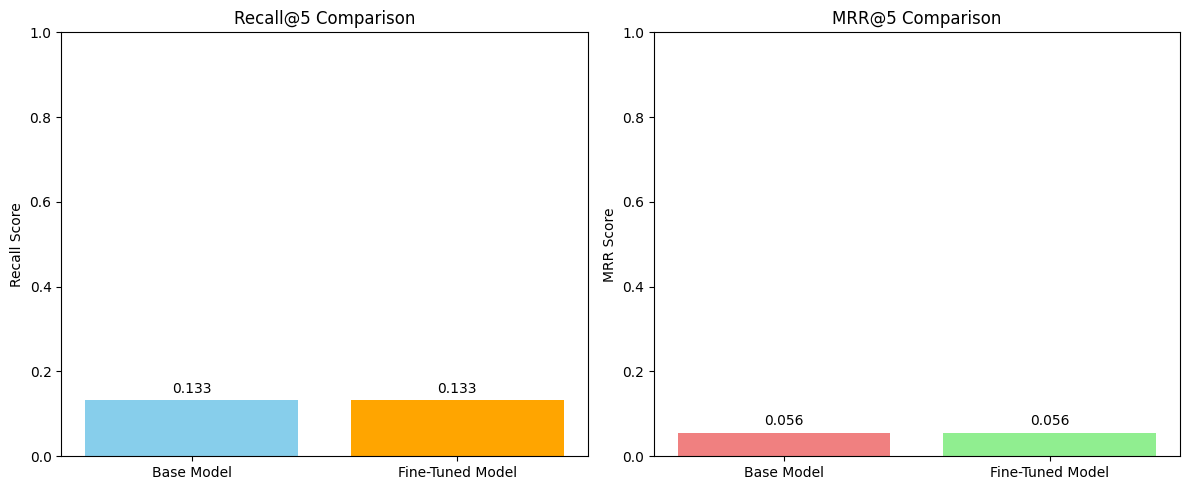

Perbandingan metrik disimpan ke: metrics_comparison.png


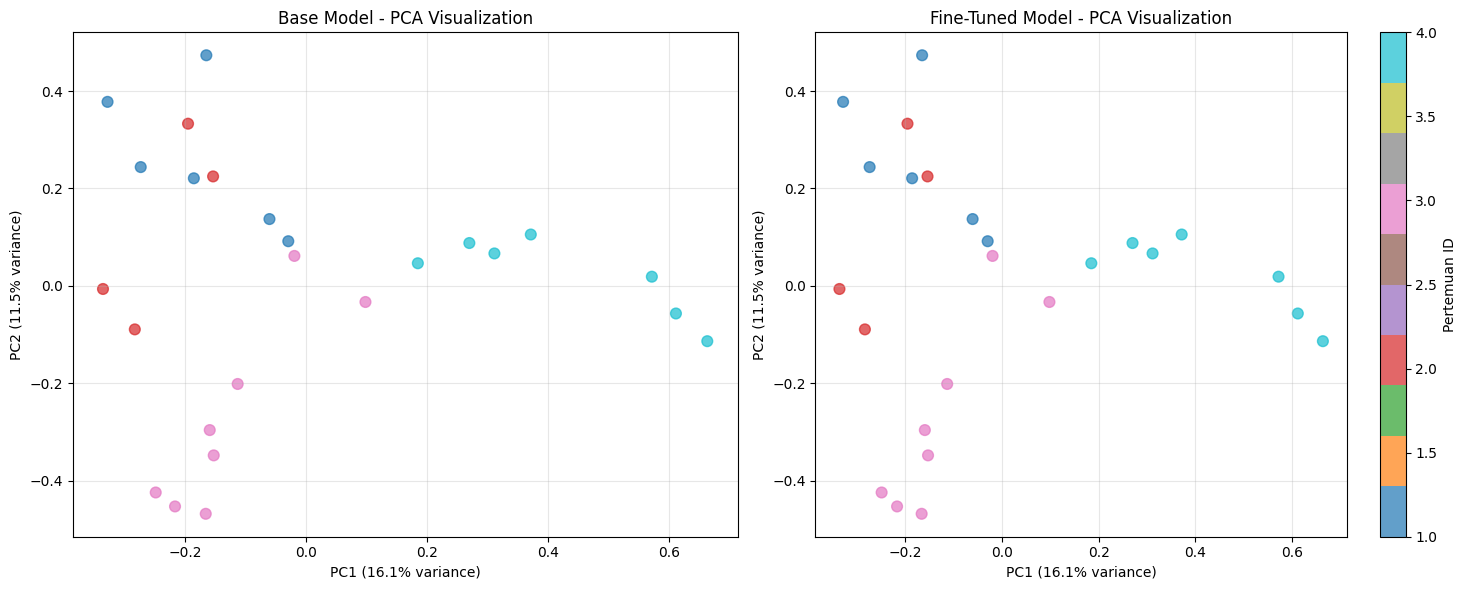

PCA visualization disimpan ke: embedding_pca_comparison.png


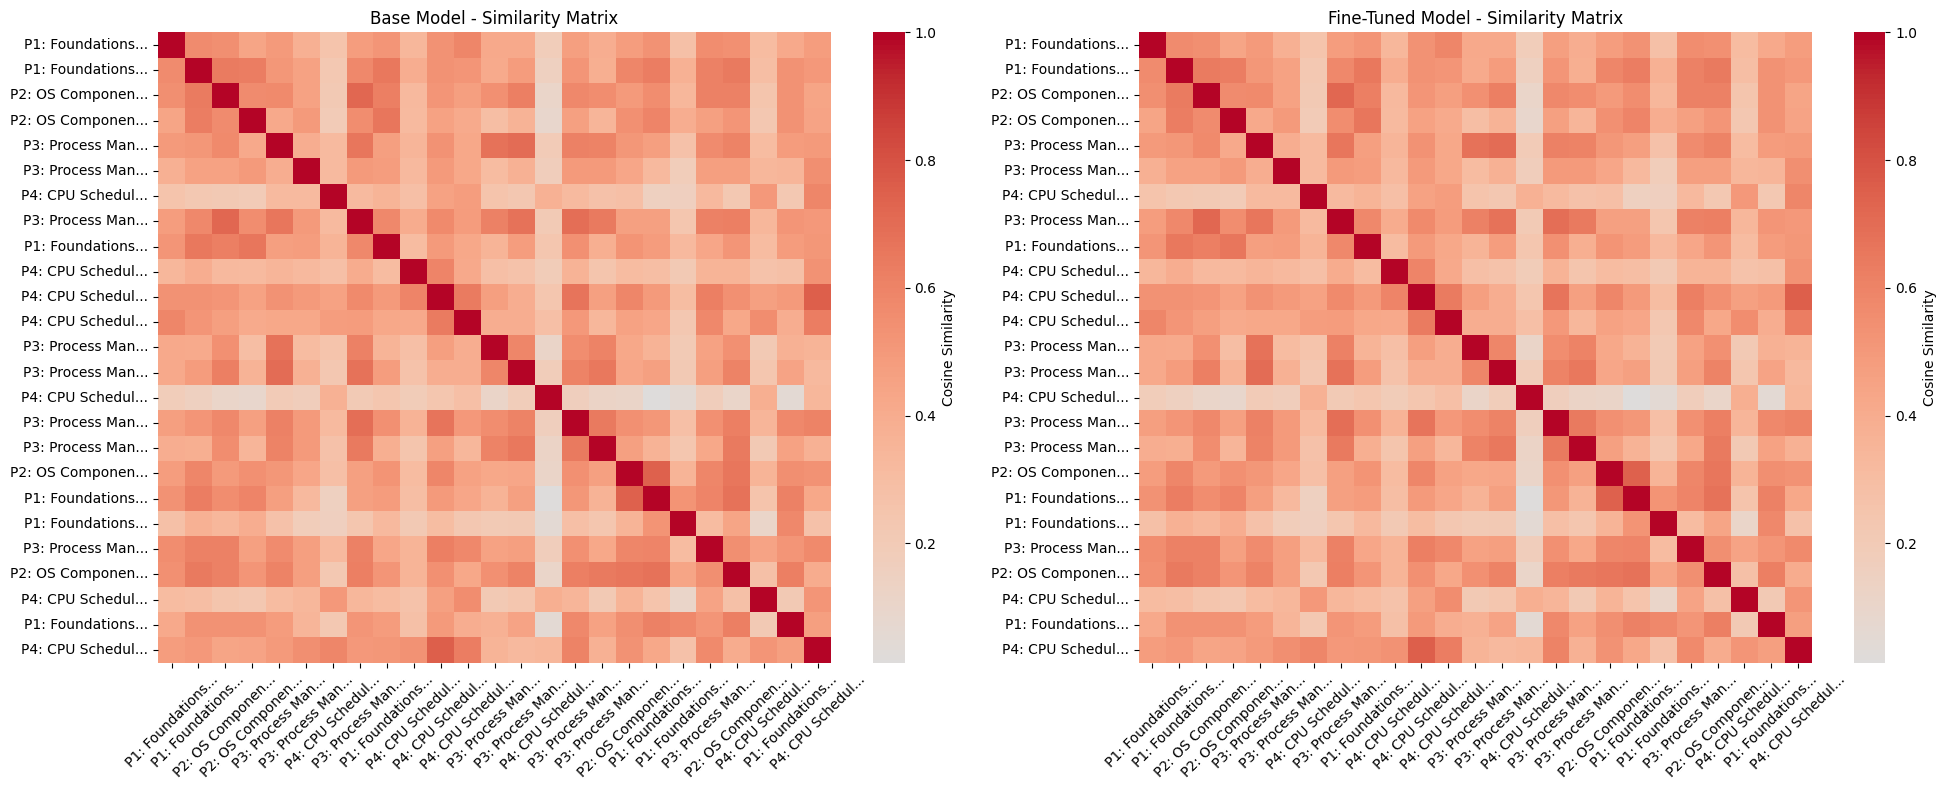

Heatmap similarity disimpan ke: similarity_heatmap_comparison.png

Statistik Perubahan Similarity:
Mean change: 0.0000
Max increase: 0.0000
Max decrease: 0.0000

🎨 VISUALISASI SELESAI!
File yang dihasilkan:
- metrics_comparison.png
- embedding_pca_comparison.png
- similarity_heatmap_comparison.png

✨ SEMUA PROSES SELESAI! ✨


In [27]:
# --- Langkah 9: Visualisasi Model Fine-Tuning ---
print(f"\n--- Langkah 9: Visualisasi Model Fine-Tuning ---")

def create_embedding_visualization(chunks_data, base_model, finetuned_model, sample_size=30):
    """Membuat data untuk visualisasi embedding"""
    if not chunks_data or not base_model:
        print("Data tidak lengkap untuk visualisasi")
        return None

    # Ambil sample data
    sample_chunks = random.sample(chunks_data, min(sample_size, len(chunks_data)))
    sample_texts = [chunk['chunk_text'][:500] for chunk in sample_chunks]  # Batasi panjang teks
    sample_labels = [f"P{chunk['pertemuan_id']}: {chunk['pertemuan_judul'][:20]}..."
                    for chunk in sample_chunks]

    print(f"Memproses {len(sample_chunks)} chunks untuk visualisasi...")

    # Generate embeddings
    base_embeddings = base_model.encode(sample_texts, show_progress_bar=True)
    finetuned_embeddings = None

    if finetuned_model:
        finetuned_embeddings = finetuned_model.encode(sample_texts, show_progress_bar=True)

    return {
        'texts': sample_texts,
        'labels': sample_labels,
        'chunks': sample_chunks,
        'base_embeddings': base_embeddings,
        'finetuned_embeddings': finetuned_embeddings
    }

def plot_metrics_comparison(metrics_base, metrics_finetuned):
    """Plot perbandingan metrik evaluasi"""
    if not metrics_base and not metrics_finetuned:
        print("Tidak ada metrik untuk divisualisasikan")
        return

    # Siapkan data
    models = []
    recall_scores = []
    mrr_scores = []

    if metrics_base:
        models.append('Base Model')
        recall_scores.append(metrics_base['avg_recall_at_k'])
        mrr_scores.append(metrics_base['avg_mrr_at_k'])

    if metrics_finetuned:
        models.append('Fine-Tuned Model')
        recall_scores.append(metrics_finetuned['avg_recall_at_k'])
        mrr_scores.append(metrics_finetuned['avg_mrr_at_k'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Recall comparison
    colors = ['skyblue', 'orange'] if len(models) > 1 else ['skyblue']
    bars1 = ax1.bar(models, recall_scores, color=colors)
    ax1.set_title(f'Recall@{EVALUATION_TOP_K} Comparison')
    ax1.set_ylabel('Recall Score')
    ax1.set_ylim(0, max(1, max(recall_scores) * 1.1))

    # Add value labels
    for bar, score in zip(bars1, recall_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    # MRR comparison
    colors_mrr = ['lightcoral', 'lightgreen'] if len(models) > 1 else ['lightcoral']
    bars2 = ax2.bar(models, mrr_scores, color=colors_mrr)
    ax2.set_title(f'MRR@{EVALUATION_TOP_K} Comparison')
    ax2.set_ylabel('MRR Score')
    ax2.set_ylim(0, max(1, max(mrr_scores) * 1.1))

    # Add value labels
    for bar, score in zip(bars2, mrr_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Perbandingan metrik disimpan ke: metrics_comparison.png")

def plot_embedding_pca_comparison(embedding_data):
    """Plot PCA comparison untuk embedding"""
    if not embedding_data:
        return

    base_embeddings = embedding_data['base_embeddings']
    finetuned_embeddings = embedding_data['finetuned_embeddings']
    chunks = embedding_data['chunks']
    pertemuan_ids = [chunk['pertemuan_id'] for chunk in chunks]

    # PCA untuk base model
    pca = PCA(n_components=2, random_state=42)
    base_2d = pca.fit_transform(base_embeddings)

    if finetuned_embeddings is not None:
        # PCA untuk fine-tuned model
        finetuned_2d = pca.fit_transform(finetuned_embeddings)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot base model
        scatter1 = ax1.scatter(base_2d[:, 0], base_2d[:, 1], c=pertemuan_ids,
                              cmap='tab10', alpha=0.7, s=60)
        ax1.set_title('Base Model - PCA Visualization')
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        ax1.grid(True, alpha=0.3)

        # Plot fine-tuned model
        scatter2 = ax2.scatter(finetuned_2d[:, 0], finetuned_2d[:, 1], c=pertemuan_ids,
                              cmap='tab10', alpha=0.7, s=60)
        ax2.set_title('Fine-Tuned Model - PCA Visualization')
        ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        ax2.grid(True, alpha=0.3)

        # Colorbar
        plt.colorbar(scatter2, ax=ax2, label='Pertemuan ID')

    else:
        # Hanya base model
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(base_2d[:, 0], base_2d[:, 1], c=pertemuan_ids,
                             cmap='tab10', alpha=0.7, s=60)
        plt.title('Base Model - PCA Visualization')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.colorbar(scatter, label='Pertemuan ID')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('embedding_pca_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("PCA visualization disimpan ke: embedding_pca_comparison.png")

def plot_similarity_heatmap(embedding_data):
    """Plot heatmap similarity antar chunks"""
    if not embedding_data:
        return

    base_embeddings = embedding_data['base_embeddings']
    finetuned_embeddings = embedding_data['finetuned_embeddings']
    labels = [label[:15] + "..." if len(label) > 15 else label
              for label in embedding_data['labels']]

    # Hitung similarity matrix
    base_similarity = cosine_similarity(base_embeddings)

    if finetuned_embeddings is not None:
        finetuned_similarity = cosine_similarity(finetuned_embeddings)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Base model heatmap
        sns.heatmap(base_similarity, xticklabels=labels, yticklabels=labels,
                   cmap='coolwarm', center=0, ax=ax1,
                   cbar_kws={'label': 'Cosine Similarity'})
        ax1.set_title('Base Model - Similarity Matrix')
        ax1.tick_params(axis='x', rotation=45)
        ax1.tick_params(axis='y', rotation=0)

        # Fine-tuned model heatmap
        sns.heatmap(finetuned_similarity, xticklabels=labels, yticklabels=labels,
                   cmap='coolwarm', center=0, ax=ax2,
                   cbar_kws={'label': 'Cosine Similarity'})
        ax2.set_title('Fine-Tuned Model - Similarity Matrix')
        ax2.tick_params(axis='x', rotation=45)
        ax2.tick_params(axis='y', rotation=0)

        plt.tight_layout()
        plt.savefig('similarity_heatmap_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Heatmap similarity disimpan ke: similarity_heatmap_comparison.png")

        # Statistik perubahan
        similarity_diff = finetuned_similarity - base_similarity
        print(f"\nStatistik Perubahan Similarity:")
        print(f"Mean change: {np.mean(similarity_diff):.4f}")
        print(f"Max increase: {np.max(similarity_diff):.4f}")
        print(f"Max decrease: {np.min(similarity_diff):.4f}")

    else:
        # Hanya base model
        plt.figure(figsize=(12, 10))
        sns.heatmap(base_similarity, xticklabels=labels, yticklabels=labels,
                   cmap='coolwarm', center=0, cbar_kws={'label': 'Cosine Similarity'})
        plt.title('Base Model - Similarity Matrix')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('similarity_heatmap_base_only.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Heatmap similarity (base model) disimpan ke: similarity_heatmap_base_only.png")

# Jalankan visualisasi
if all_processed_chunks_with_metadata and base_embedding_model_instance:
    print("Memulai pembuatan visualisasi...")

    # Buat data embedding untuk visualisasi
    embedding_vis_data = create_embedding_visualization(
        all_processed_chunks_with_metadata,
        base_embedding_model_instance,
        finetuned_embedding_model_instance,
        sample_size=25  # Sample size yang reasonable
    )

    if embedding_vis_data:
        print("Data embedding berhasil dibuat. Membuat visualisasi...")

        # 1. Metrics Comparison
        plot_metrics_comparison(metrics_base, metrics_finetuned)

        # 2. PCA Visualization
        plot_embedding_pca_comparison(embedding_vis_data)

        # 3. Similarity Heatmap
        plot_similarity_heatmap(embedding_vis_data)

        print("\n🎨 VISUALISASI SELESAI!")
        print("File yang dihasilkan:")
        print("- metrics_comparison.png")
        print("- embedding_pca_comparison.png")
        if finetuned_embedding_model_instance:
            print("- similarity_heatmap_comparison.png")
        else:
            print("- similarity_heatmap_base_only.png")

else:
    print("Data tidak lengkap untuk membuat visualisasi")

print("\n✨ SEMUA PROSES SELESAI! ✨")

In [28]:
# --- Summary Report ---
print(f"\n--- LAPORAN AKHIR ---")

print(f"📊 Dataset yang Diproses:")
print(f"   - Total chunks: {len(all_processed_chunks_with_metadata)}")
print(f"   - Total pertemuan: {len(set(chunk['pertemuan_id'] for chunk in all_processed_chunks_with_metadata))}")

print(f"\n🤖 Model yang Dibuat:")
print(f"   - Base model: {BASE_EMBEDDING_MODEL_NAME}")
if finetuned_embedding_model_instance:
    print(f"   - Fine-tuned model: {FINETUNED_EMBEDDING_MODEL_SAVE_PATH}")
else:
    print(f"   - Fine-tuned model: Tidak dibuat")

print(f"\n📈 Hasil Evaluasi:")
if metrics_base:
    print(f"   - Base Recall@{EVALUATION_TOP_K}: {metrics_base['avg_recall_at_k']:.4f}")
    print(f"   - Base MRR@{EVALUATION_TOP_K}: {metrics_base['avg_mrr_at_k']:.4f}")
if metrics_finetuned:
    print(f"   - Finetuned Recall@{EVALUATION_TOP_K}: {metrics_finetuned['avg_recall_at_k']:.4f}")
    print(f"   - Finetuned MRR@{EVALUATION_TOP_K}: {metrics_finetuned['avg_mrr_at_k']:.4f}")

print(f"\n📁 File Output:")
print(f"   - Base FAISS index: {OUTPUT_FAISS_INDEX_BASE}")
print(f"   - Finetuned FAISS index: {OUTPUT_FAISS_INDEX_FINETUNED}")
print(f"   - Chunks metadata: {OUTPUT_JSON_CHUNKS_FINETUNED}")
print(f"   - Dataset zip: dataset_zipped_for_download.zip")

print(f"\n🎯 Rekomendasi:")
if metrics_finetuned and metrics_base:
    if metrics_finetuned['avg_recall_at_k'] > metrics_base['avg_recall_at_k']:
        print("   ✅ Gunakan model fine-tuned untuk produksi")
    else:
        print("   ⚠️  Pertimbangkan untuk menggunakan base model atau improve training data")
else:
    print("   ℹ️  Lakukan evaluasi lebih lanjut untuk memvalidasi performa model")


--- LAPORAN AKHIR ---
📊 Dataset yang Diproses:
   - Total chunks: 56
   - Total pertemuan: 4

🤖 Model yang Dibuat:
   - Base model: all-MiniLM-L6-v2
   - Fine-tuned model: dataset/SistemOperasi/finetuned_embedding_model_sistem_operasi

📈 Hasil Evaluasi:
   - Base Recall@5: 0.1333
   - Base MRR@5: 0.0556
   - Finetuned Recall@5: 0.1333
   - Finetuned MRR@5: 0.0556

📁 File Output:
   - Base FAISS index: dataset/SistemOperasi/vector_store_base.index
   - Finetuned FAISS index: dataset/SistemOperasi/vector_store_finetuned.index
   - Chunks metadata: dataset/SistemOperasi/processed_chunks_metadata_finetuned.json
   - Dataset zip: dataset_zipped_for_download.zip

🎯 Rekomendasi:
   ⚠️  Pertimbangkan untuk menggunakan base model atau improve training data



--- Langkah 9: Visualisasi Model Fine-Tuning ---
Memulai pembuatan visualisasi...
Memproses 30 chunks untuk visualisasi...
Data embedding berhasil dibuat. Membuat visualisasi...
Menjalankan t-SNE untuk model dasar...
Menjalankan t-SNE untuk model fine-tuned...


Visualisasi t-SNE disimpan ke: embedding_tsne_comparison.html


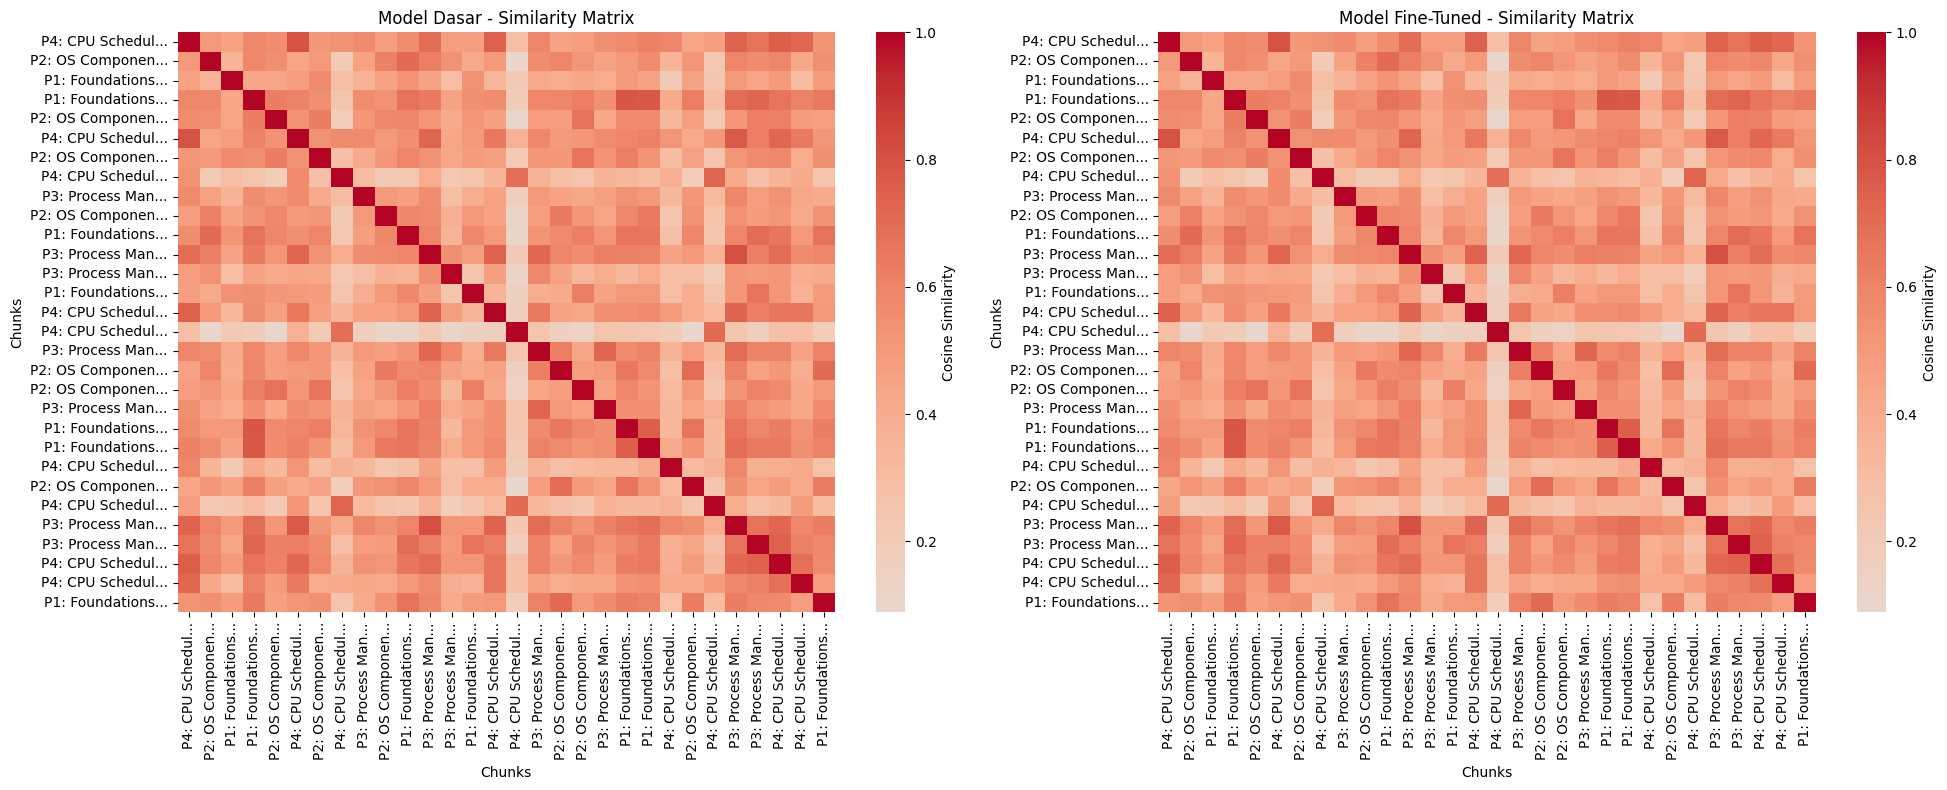

Heatmap similarity disimpan ke: similarity_heatmap_comparison.png

Statistik Perubahan Similarity:
Mean change: 0.0000
Std change: 0.0000
Max increase: 0.0000
Max decrease: 0.0000


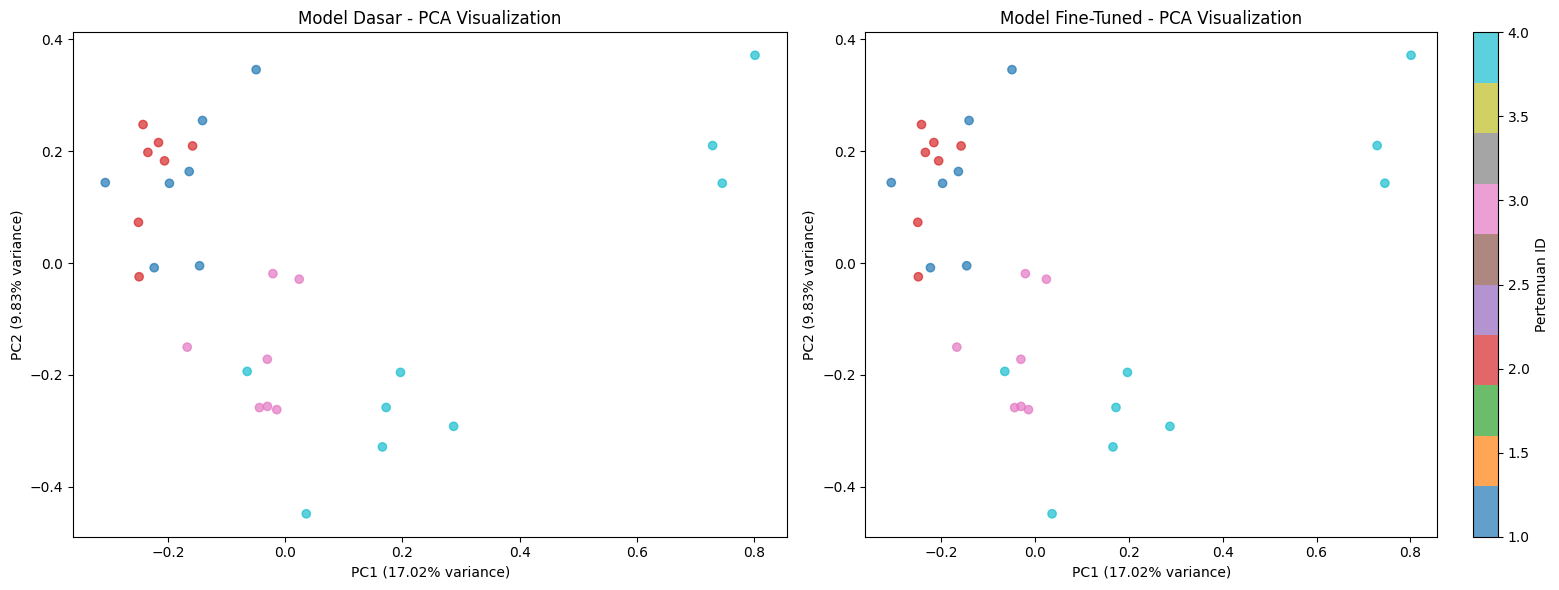

PCA visualization disimpan ke: embedding_pca_comparison.png


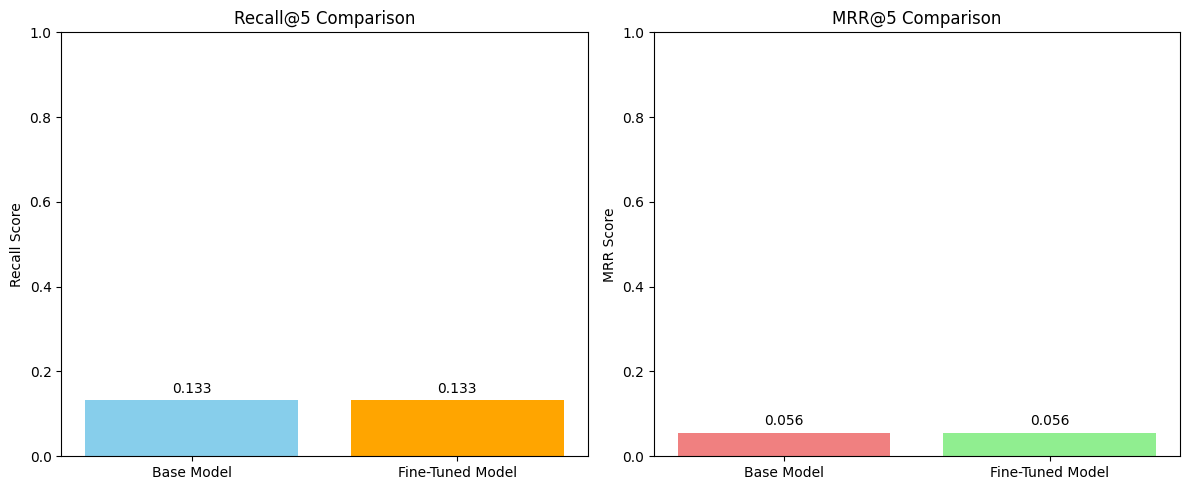

Perbandingan metrik disimpan ke: metrics_comparison.png


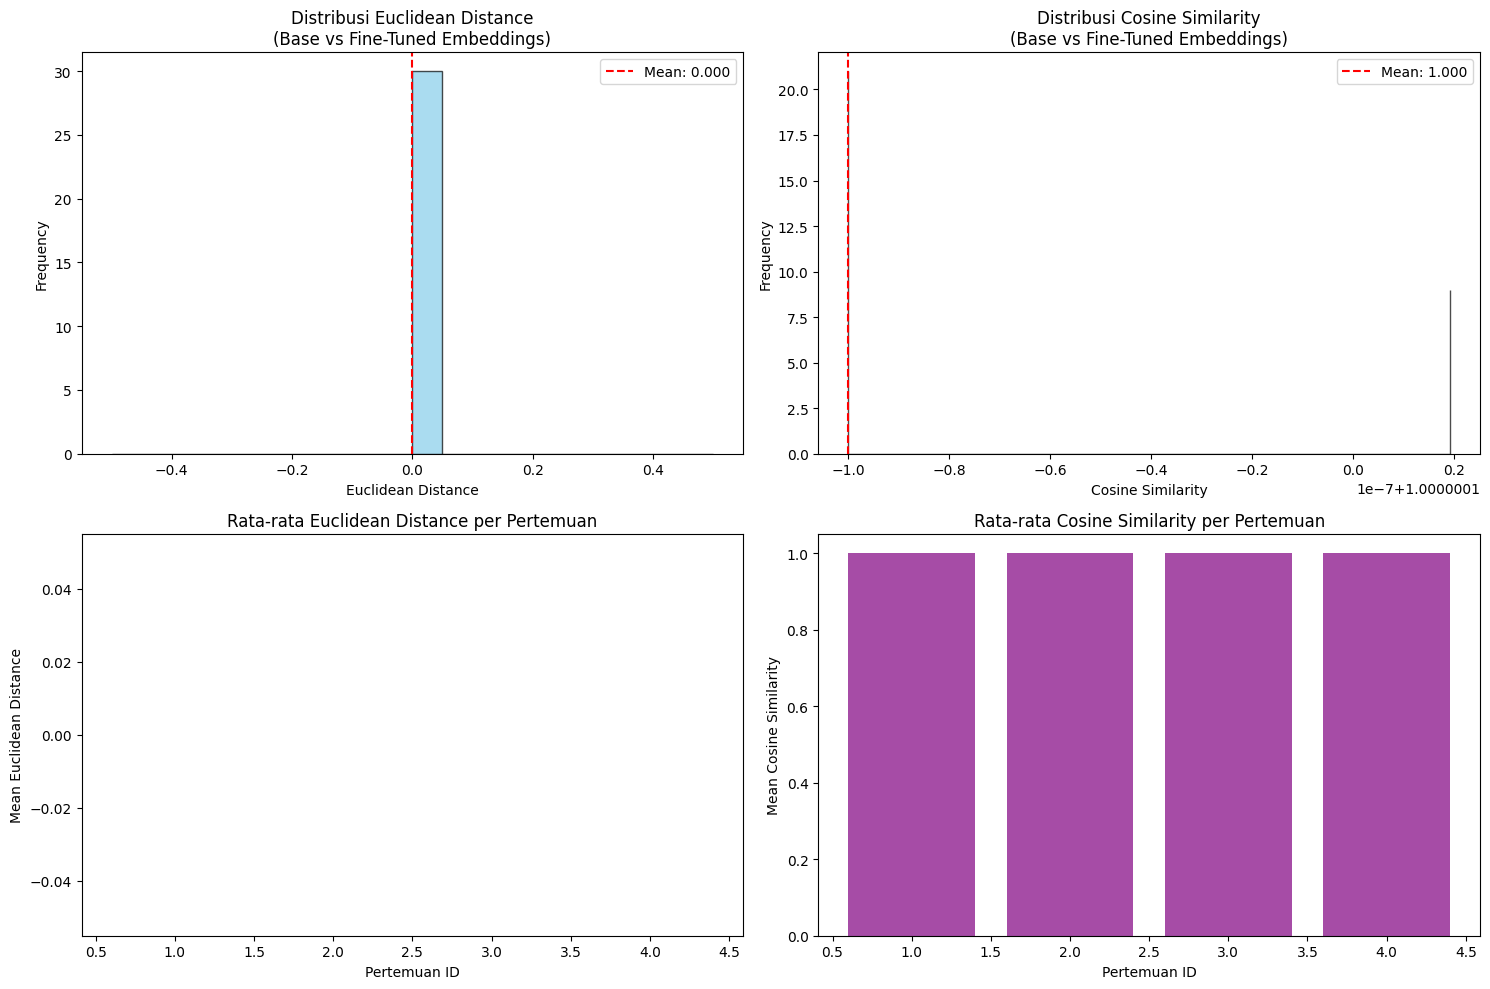

Analisis jarak embedding disimpan ke: embedding_distance_analysis.png

Statistik Perubahan Embedding:
Mean Euclidean Distance: 0.0000
Std Euclidean Distance: 0.0000
Mean Cosine Similarity: 1.0000
Std Cosine Similarity: 0.0000

🎨 VISUALISASI SELESAI!
File yang dihasilkan:
- embedding_tsne_comparison.html
- similarity_heatmap_comparison.png
- embedding_pca_comparison.png
- metrics_comparison.png
- embedding_distance_analysis.png

✨ SEMUA PROSES SELESAI! ✨


In [29]:
# ...existing code...

# --- Langkah 9: Visualisasi Model Fine-Tuning ---
print(f"\n--- Langkah 9: Visualisasi Model Fine-Tuning ---")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_embedding_visualization(chunks_data, base_model, finetuned_model, sample_size=50):
    """
    Membuat visualisasi perbandingan embedding sebelum dan sesudah fine-tuning
    """
    if not chunks_data or not base_model:
        print("Data tidak lengkap untuk visualisasi")
        return

    # Ambil sample data untuk visualisasi (untuk performa)
    sample_chunks = random.sample(chunks_data, min(sample_size, len(chunks_data)))
    sample_texts = [chunk['chunk_text'] for chunk in sample_chunks]
    sample_labels = [f"P{chunk['pertemuan_id']}: {chunk['pertemuan_judul'][:20]}..."
                    for chunk in sample_chunks]

    print(f"Memproses {len(sample_chunks)} chunks untuk visualisasi...")

    # Generate embeddings
    base_embeddings = base_model.encode(sample_texts)

    if finetuned_model:
        finetuned_embeddings = finetuned_model.encode(sample_texts)
    else:
        print("Model fine-tuned tidak tersedia, hanya menampilkan visualisasi model dasar")
        finetuned_embeddings = None

    return {
        'texts': sample_texts,
        'labels': sample_labels,
        'chunks': sample_chunks,
        'base_embeddings': base_embeddings,
        'finetuned_embeddings': finetuned_embeddings
    }

def plot_embedding_comparison_tsne(embedding_data):
    """
    Plot perbandingan embedding menggunakan t-SNE
    """
    if not embedding_data:
        return

    base_embeddings = embedding_data['base_embeddings']
    finetuned_embeddings = embedding_data['finetuned_embeddings']
    labels = embedding_data['labels']
    chunks = embedding_data['chunks']

    # Persiapkan data untuk plotting
    pertemuan_ids = [chunk['pertemuan_id'] for chunk in chunks]
    pertemuan_colors = [f"Pertemuan {pid}" for pid in pertemuan_ids]

    fig = make_subplots(
        rows=1, cols=2 if finetuned_embeddings is not None else 1,
        subplot_titles=(['Model Dasar (Base)', 'Model Fine-Tuned'] if finetuned_embeddings is not None
                       else ['Model Dasar (Base)']),
        specs=[[{"secondary_y": False}, {"secondary_y": False}]] if finetuned_embeddings is not None
              else [[{"secondary_y": False}]]
    )

    # t-SNE untuk model dasar
    print("Menjalankan t-SNE untuk model dasar...")
    tsne_base = TSNE(n_components=2, random_state=42, perplexity=min(30, len(base_embeddings)-1))
    base_2d = tsne_base.fit_transform(base_embeddings)

    # Plot model dasar
    scatter_base = go.Scatter(
        x=base_2d[:, 0],
        y=base_2d[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color=pertemuan_ids,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Pertemuan ID")
        ),
        text=labels,
        hovertemplate='<b>%{text}</b><br>X: %{x}<br>Y: %{y}<extra></extra>',
        name='Base Model'
    )

    fig.add_trace(scatter_base, row=1, col=1)

    # t-SNE dan plot untuk model fine-tuned (jika tersedia)
    if finetuned_embeddings is not None:
        print("Menjalankan t-SNE untuk model fine-tuned...")
        tsne_finetuned = TSNE(n_components=2, random_state=42, perplexity=min(30, len(finetuned_embeddings)-1))
        finetuned_2d = tsne_finetuned.fit_transform(finetuned_embeddings)

        scatter_finetuned = go.Scatter(
            x=finetuned_2d[:, 0],
            y=finetuned_2d[:, 1],
            mode='markers',
            marker=dict(
                size=8,
                color=pertemuan_ids,
                colorscale='Viridis',
                showscale=False
            ),
            text=labels,
            hovertemplate='<b>%{text}</b><br>X: %{x}<br>Y: %{y}<extra></extra>',
            name='Fine-Tuned Model'
        )

        fig.add_trace(scatter_finetuned, row=1, col=2)

    fig.update_layout(
        title="Perbandingan Embedding: t-SNE Visualization",
        height=600,
        showlegend=False
    )

    fig.show()

    # Simpan plot
    fig.write_html("embedding_tsne_comparison.html")
    print("Visualisasi t-SNE disimpan ke: embedding_tsne_comparison.html")

def plot_similarity_heatmap(embedding_data):
    """
    Plot heatmap similarity antar chunks
    """
    if not embedding_data:
        return

    base_embeddings = embedding_data['base_embeddings']
    finetuned_embeddings = embedding_data['finetuned_embeddings']
    labels = embedding_data['labels']

    # Hitung similarity matrix
    base_similarity = cosine_similarity(base_embeddings)

    if finetuned_embeddings is not None:
        finetuned_similarity = cosine_similarity(finetuned_embeddings)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Base model heatmap
        sns.heatmap(base_similarity,
                   xticklabels=[label[:15] + "..." if len(label) > 15 else label for label in labels],
                   yticklabels=[label[:15] + "..." if len(label) > 15 else label for label in labels],
                   cmap='coolwarm', center=0, ax=ax1, cbar_kws={'label': 'Cosine Similarity'})
        ax1.set_title('Model Dasar - Similarity Matrix')
        ax1.set_xlabel('Chunks')
        ax1.set_ylabel('Chunks')

        # Fine-tuned model heatmap
        sns.heatmap(finetuned_similarity,
                   xticklabels=[label[:15] + "..." if len(label) > 15 else label for label in labels],
                   yticklabels=[label[:15] + "..." if len(label) > 15 else label for label in labels],
                   cmap='coolwarm', center=0, ax=ax2, cbar_kws={'label': 'Cosine Similarity'})
        ax2.set_title('Model Fine-Tuned - Similarity Matrix')
        ax2.set_xlabel('Chunks')
        ax2.set_ylabel('Chunks')

        plt.tight_layout()
        plt.savefig('similarity_heatmap_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Heatmap similarity disimpan ke: similarity_heatmap_comparison.png")

        # Hitung statistik perubahan similarity
        similarity_diff = finetuned_similarity - base_similarity
        print(f"\nStatistik Perubahan Similarity:")
        print(f"Mean change: {np.mean(similarity_diff):.4f}")
        print(f"Std change: {np.std(similarity_diff):.4f}")
        print(f"Max increase: {np.max(similarity_diff):.4f}")
        print(f"Max decrease: {np.min(similarity_diff):.4f}")

    else:
        # Hanya model dasar
        plt.figure(figsize=(12, 10))
        sns.heatmap(base_similarity,
                   xticklabels=[label[:15] + "..." if len(label) > 15 else label for label in labels],
                   yticklabels=[label[:15] + "..." if len(label) > 15 else label for label in labels],
                   cmap='coolwarm', center=0, cbar_kws={'label': 'Cosine Similarity'})
        plt.title('Model Dasar - Similarity Matrix')
        plt.xlabel('Chunks')
        plt.ylabel('Chunks')
        plt.tight_layout()
        plt.savefig('similarity_heatmap_base_only.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Heatmap similarity (model dasar) disimpan ke: similarity_heatmap_base_only.png")

def plot_embedding_pca(embedding_data):
    """
    Plot PCA visualization untuk embedding
    """
    if not embedding_data:
        return

    base_embeddings = embedding_data['base_embeddings']
    finetuned_embeddings = embedding_data['finetuned_embeddings']
    chunks = embedding_data['chunks']

    # PCA untuk model dasar
    pca = PCA(n_components=2)
    base_pca = pca.fit_transform(base_embeddings)

    if finetuned_embeddings is not None:
        finetuned_pca = pca.fit_transform(finetuned_embeddings)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Plot base model
        pertemuan_ids = [chunk['pertemuan_id'] for chunk in chunks]
        scatter1 = ax1.scatter(base_pca[:, 0], base_pca[:, 1], c=pertemuan_ids, cmap='tab10', alpha=0.7)
        ax1.set_title('Model Dasar - PCA Visualization')
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

        # Plot fine-tuned model
        scatter2 = ax2.scatter(finetuned_pca[:, 0], finetuned_pca[:, 1], c=pertemuan_ids, cmap='tab10', alpha=0.7)
        ax2.set_title('Model Fine-Tuned - PCA Visualization')
        ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

        # Colorbar
        plt.colorbar(scatter2, ax=ax2, label='Pertemuan ID')

        plt.tight_layout()
        plt.savefig('embedding_pca_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("PCA visualization disimpan ke: embedding_pca_comparison.png")

    else:
        plt.figure(figsize=(10, 8))
        pertemuan_ids = [chunk['pertemuan_id'] for chunk in chunks]
        scatter = plt.scatter(base_pca[:, 0], base_pca[:, 1], c=pertemuan_ids, cmap='tab10', alpha=0.7)
        plt.title('Model Dasar - PCA Visualization')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.colorbar(scatter, label='Pertemuan ID')
        plt.tight_layout()
        plt.savefig('embedding_pca_base_only.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("PCA visualization (model dasar) disimpan ke: embedding_pca_base_only.png")

def plot_metrics_comparison(metrics_base, metrics_finetuned):
    """
    Plot perbandingan metrik evaluasi
    """
    if not metrics_base:
        print("Tidak ada metrik untuk divisualisasikan")
        return

    # Siapkan data
    if metrics_finetuned:
        models = ['Base Model', 'Fine-Tuned Model']
        recall_scores = [metrics_base['avg_recall_at_k'], metrics_finetuned['avg_recall_at_k']]
        mrr_scores = [metrics_base['avg_mrr_at_k'], metrics_finetuned['avg_mrr_at_k']]
    else:
        models = ['Base Model']
        recall_scores = [metrics_base['avg_recall_at_k']]
        mrr_scores = [metrics_base['avg_mrr_at_k']]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Recall comparison
    bars1 = ax1.bar(models, recall_scores, color=['skyblue', 'orange'] if len(models) > 1 else ['skyblue'])
    ax1.set_title(f'Recall@{EVALUATION_TOP_K} Comparison')
    ax1.set_ylabel('Recall Score')
    ax1.set_ylim(0, 1)

    # Add value labels on bars
    for bar, score in zip(bars1, recall_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    # MRR comparison
    bars2 = ax2.bar(models, mrr_scores, color=['lightcoral', 'lightgreen'] if len(models) > 1 else ['lightcoral'])
    ax2.set_title(f'MRR@{EVALUATION_TOP_K} Comparison')
    ax2.set_ylabel('MRR Score')
    ax2.set_ylim(0, 1)

    # Add value labels on bars
    for bar, score in zip(bars2, mrr_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Perbandingan metrik disimpan ke: metrics_comparison.png")

def create_embedding_distance_analysis(embedding_data):
    """
    Analisis jarak embedding sebelum dan sesudah fine-tuning
    """
    if not embedding_data or embedding_data['finetuned_embeddings'] is None:
        print("Data fine-tuned tidak tersedia untuk analisis jarak")
        return

    base_embeddings = embedding_data['base_embeddings']
    finetuned_embeddings = embedding_data['finetuned_embeddings']
    chunks = embedding_data['chunks']

    # Hitung perubahan magnitude per embedding
    embedding_changes = []
    for i, (base_emb, fine_emb) in enumerate(zip(base_embeddings, finetuned_embeddings)):
        # Euclidean distance between embeddings
        euclidean_dist = np.linalg.norm(fine_emb - base_emb)
        # Cosine similarity change
        cos_sim_base_fine = np.dot(base_emb, fine_emb) / (np.linalg.norm(base_emb) * np.linalg.norm(fine_emb))

        embedding_changes.append({
            'chunk_id': i,
            'pertemuan_id': chunks[i]['pertemuan_id'],
            'pertemuan_judul': chunks[i]['pertemuan_judul'],
            'euclidean_distance': euclidean_dist,
            'cosine_similarity': cos_sim_base_fine
        })

    # Convert to DataFrame untuk analisis
    df_changes = pd.DataFrame(embedding_changes)

    # Plot distribusi perubahan
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Euclidean distance distribution
    ax1.hist(df_changes['euclidean_distance'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Distribusi Euclidean Distance\n(Base vs Fine-Tuned Embeddings)')
    ax1.set_xlabel('Euclidean Distance')
    ax1.set_ylabel('Frequency')
    ax1.axvline(df_changes['euclidean_distance'].mean(), color='red', linestyle='--',
                label=f'Mean: {df_changes["euclidean_distance"].mean():.3f}')
    ax1.legend()

    # Cosine similarity distribution
    ax2.hist(df_changes['cosine_similarity'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    ax2.set_title('Distribusi Cosine Similarity\n(Base vs Fine-Tuned Embeddings)')
    ax2.set_xlabel('Cosine Similarity')
    ax2.set_ylabel('Frequency')
    ax2.axvline(df_changes['cosine_similarity'].mean(), color='red', linestyle='--',
                label=f'Mean: {df_changes["cosine_similarity"].mean():.3f}')
    ax2.legend()

    # Changes by pertemuan
    pertemuan_stats = df_changes.groupby('pertemuan_id').agg({
        'euclidean_distance': 'mean',
        'cosine_similarity': 'mean'
    }).reset_index()

    ax3.bar(pertemuan_stats['pertemuan_id'], pertemuan_stats['euclidean_distance'],
            alpha=0.7, color='orange')
    ax3.set_title('Rata-rata Euclidean Distance per Pertemuan')
    ax3.set_xlabel('Pertemuan ID')
    ax3.set_ylabel('Mean Euclidean Distance')

    ax4.bar(pertemuan_stats['pertemuan_id'], pertemuan_stats['cosine_similarity'],
            alpha=0.7, color='purple')
    ax4.set_title('Rata-rata Cosine Similarity per Pertemuan')
    ax4.set_xlabel('Pertemuan ID')
    ax4.set_ylabel('Mean Cosine Similarity')

    plt.tight_layout()
    plt.savefig('embedding_distance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Analisis jarak embedding disimpan ke: embedding_distance_analysis.png")

    # Print statistik
    print(f"\nStatistik Perubahan Embedding:")
    print(f"Mean Euclidean Distance: {df_changes['euclidean_distance'].mean():.4f}")
    print(f"Std Euclidean Distance: {df_changes['euclidean_distance'].std():.4f}")
    print(f"Mean Cosine Similarity: {df_changes['cosine_similarity'].mean():.4f}")
    print(f"Std Cosine Similarity: {df_changes['cosine_similarity'].std():.4f}")

# Jalankan visualisasi
if all_processed_chunks_with_metadata and base_embedding_model_instance:
    print("Memulai pembuatan visualisasi...")

    # Buat data embedding untuk visualisasi
    embedding_vis_data = create_embedding_visualization(
        all_processed_chunks_with_metadata,
        base_embedding_model_instance,
        finetuned_embedding_model_instance,
        sample_size=30  # Kurangi sample size untuk performa yang lebih baik
    )

    if embedding_vis_data:
        print("Data embedding berhasil dibuat. Membuat visualisasi...")

        # 1. t-SNE Comparison
        plot_embedding_comparison_tsne(embedding_vis_data)

        # 2. Similarity Heatmap
        plot_similarity_heatmap(embedding_vis_data)

        # 3. PCA Visualization
        plot_embedding_pca(embedding_vis_data)

        # 4. Metrics Comparison
        plot_metrics_comparison(metrics_base, metrics_finetuned)

        # 5. Embedding Distance Analysis (hanya jika ada fine-tuned model)
        if finetuned_embedding_model_instance:
            create_embedding_distance_analysis(embedding_vis_data)

        print("\n🎨 VISUALISASI SELESAI!")
        print("File yang dihasilkan:")
        print("- embedding_tsne_comparison.html")
        print("- similarity_heatmap_comparison.png")
        print("- embedding_pca_comparison.png")
        print("- metrics_comparison.png")
        if finetuned_embedding_model_instance:
            print("- embedding_distance_analysis.png")

else:
    print("Data tidak lengkap untuk membuat visualisasi")

print("\n✨ SEMUA PROSES SELESAI! ✨")